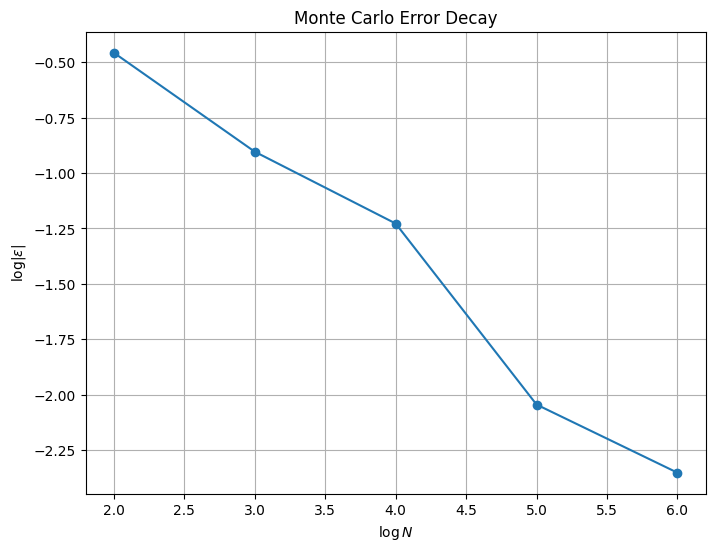

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def estimate_sphere_volume(N):
    """Monte Carlo estimation of unit sphere volume in 3D"""
    # Generate N random points in the cube [-1,1] x [-1,1] x [-1,1]
    x = np.random.uniform(-1, 1, N)
    y = np.random.uniform(-1, 1, N)
    z = np.random.uniform(-1, 1, N)
    
    # Count how many points are inside the unit sphere
    inside_sphere = (x**2 + y**2 + z**2) <= 1
    num_inside = np.sum(inside_sphere)
    
    # Estimate the volume
    volume_cube = 8  # Cube volume (2x2x2)
    estimated_volume = volume_cube * (num_inside / N)
    
    return estimated_volume

# Exact volume of unit sphere
exact_volume = (4/3) * np.pi
N_values = [10**i for i in range(2, 7)]  # Sample sizes: 10^2 to 10^6
errors = []

# Compute errors for different sample sizes
for N in N_values:
    estimated_volume = estimate_sphere_volume(N)
    error = abs(estimated_volume - exact_volume)
    errors.append(error)

# Plot log-log error vs sample size
plt.figure(figsize=(8,6))
plt.plot(np.log10(N_values), np.log10(errors), marker='o', linestyle='-')
plt.xlabel(r'$\log N$')
plt.ylabel(r'$\log |\epsilon|$')
plt.title('Monte Carlo Error Decay')
plt.grid(True)
plt.show()


In [12]:
from mpi4py import MPI
import numpy as np

def monte_carlo_volume(N_local):
    """Monte Carlo estimation of unit sphere volume in 3D for a local process"""
    x = np.random.uniform(-1, 1, N_local)
    y = np.random.uniform(-1, 1, N_local)
    z = np.random.uniform(-1, 1, N_local)
    
    inside_sphere = (x**2 + y**2 + z**2) <= 1
    num_inside = np.sum(inside_sphere)
    
    return num_inside

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

N_total = int(1e6)  # Total sample points
N_local = N_total // size  # Each process handles part of the work

local_count = monte_carlo_volume(N_local)

# Gather results from all processes
global_count = comm.reduce(local_count, op=MPI.SUM, root=0)

if rank == 0:
    volume_cube = 8
    estimated_volume = volume_cube * (global_count / N_total)
    exact_volume = (4/3) * np.pi
    error = abs(estimated_volume - exact_volume)
    
    print(f"Estimated Volume: {estimated_volume}")
    print(f"Exact Volume: {exact_volume}")
    print(f"Error: {error}")


Estimated Volume: 4.187416
Exact Volume: 4.1887902047863905
Error: 0.0013742047863907203


In [63]:
from mpi4py import MPI
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def monte_carlo_volume(N_local):
    """Monte Carlo estimation of unit sphere volume in 3D for a local thread."""
    x = np.random.uniform(-1, 1, N_local)
    y = np.random.uniform(-1, 1, N_local)
    z = np.random.uniform(-1, 1, N_local)
    
    inside_sphere = (x**2 + y**2 + z**2) <= 1
    return np.sum(inside_sphere)

def parallel_monte_carlo(N_local, num_threads):
    """Run Monte Carlo estimation in parallel using multiple threads inside an MPI process."""
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Split the work among threads
        N_per_thread = N_local // num_threads
        results = list(executor.map(monte_carlo_volume, [N_per_thread] * num_threads))
    
    return sum(results)

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

N_total = int(1e6)  # Total sample points
N_local = N_total // size  # Each MPI process handles part of the work

# Use only 1, 2, 4, 8, and 16 threads
thread_counts = [1, 2, 4, 8, 16]

# Print header (only for rank 0)
if rank == 0:
    print("Threads | Estimated Volume | Exact Volume | Error")
    print("--------------------------------------------------")

for num_threads in thread_counts:
    local_count = parallel_monte_carlo(N_local, num_threads)

    # Gather results from all MPI processes
    global_count = comm.reduce(local_count, op=MPI.SUM, root=0)

    if rank == 0:
        volume_cube = 8
        estimated_volume = volume_cube * (global_count / N_total)
        exact_volume = (4/3) * np.pi
        error = abs(estimated_volume - exact_volume)

        print(f"{num_threads:7} | {estimated_volume:.6f} | {exact_volume:.6f} | {error:.6f}")


Threads | Estimated Volume | Exact Volume | Error
--------------------------------------------------
      1 | 4.190472 | 4.188790 | 0.001682
      2 | 4.192232 | 4.188790 | 0.003442
      4 | 4.190848 | 4.188790 | 0.002058
      8 | 4.186040 | 4.188790 | 0.002750
     16 | 4.188016 | 4.188790 | 0.000774


In [19]:
from mpi4py import MPI
import numpy as np

def monte_carlo_integral_mpi(N_local):
    """Monte Carlo estimation of the given integral for a local process."""
    x = np.random.uniform(-1, 1, N_local)
    y = np.random.uniform(-1, 1, N_local)
    z = np.random.uniform(-1, 1, N_local)
    
    inside_sphere = (x**2 + y**2 + z**2) <= 1
    f_values = (1 + x**2 + y**2 + z**2)[inside_sphere]
    
    return np.sum(f_values), np.sum(inside_sphere)

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

N_total = int(1e6)  # Total sample points
N_local = N_total // size  # Each process handles part of the work

local_sum_f, local_count = monte_carlo_integral_mpi(N_local)

# Gather results from all processes
global_sum_f = comm.reduce(local_sum_f, op=MPI.SUM, root=0)
global_count = comm.reduce(local_count, op=MPI.SUM, root=0)

if rank == 0:
    V_sphere = (4/3) * np.pi  # Exact volume of unit sphere
    estimated_Q = V_sphere * (global_sum_f / global_count)
    exact_Q = (32/15) * np.pi
    error = abs(estimated_Q - exact_Q)
    
    print(f"Estimated Q: {estimated_Q}")
    print(f"Exact Q: {exact_Q}")
    print(f"Error: {error}")


Estimated Q: 6.699695988830379
Exact Q: 6.702064327658225
Error: 0.0023683388278463724
